<a href="https://colab.research.google.com/github/DBaudry/Graph_Matching/blob/DB/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compress Sensing - Project report
###* Dorian Baudry, Alexandre Filiot - March 2019 *

https://v2.overleaf.com/project/5c76c42c2a7f6e16e20a03f8


## Abstract


As part of the course on compress sensing, we studied the 2 following articles: "Balanced Graph Matching" from Cour et al. (2006) and "A Fast Semidefinite Approach to Solving Binary Quadratic Problems" from Wang et al. (2013). We mainly focused on the first article... (**à voir selon notre état d'avancement**).  



In [1]:
import numpy as np
from scipy.linalg import eigh
from copy import copy
import cvxopt as cvx
from tqdm import tqdm_notebook as tqdm
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction 


The topic under scrutiny is about graph matching. Graphs have been widely used in various computer vision applications and machine learning for their ability to conveniently and efficiently represent object. Once graph-based representations are constructed, it is essential to know how to compare graphs. Whether in order to quantify the similarity between the latter (for applications in supervised or unsupervised classification) or, mostly, detect similar parts (identification of similar interesting patterns in the data). That is what graph matching aims at: seeking a mapping between vertices of two graphs which optimally aligns their structure. For example, one can cite the task of 2D and 3D shapes matching or deformable objects matching. In those applications, a test object is compared to a set of template ones. Each of those images is fully characterized by a graph whose nodes represent feature points (like spatial location, orientation and any useful image feature descriptors) and edges represent relationships between feature points. More broadly, the features could consist of points, lines, shape descriptors or interest points, depending on the specific application.

Classical formulations of graph matching problems concern one-to-one correspondences between graphs. However, it is more accurate to consider at least one-to-many correspondances as graphs rarely match perfectly. Indeed,  a given point from the test image can be related to a cluster of nodes in the template image graph rather than only one point. For example, a point from the test image can match a set of points from the template images depending which characterize the same part of the image but with slightly different attributes due to noise or object view. One-to-one, one-to-many or many-to-many matching problems can be formulated as a discrete optimization problem where the objective function to maximize in the overall similarity, or affinity, of matched edge attributes. Despite some restricted settings where this problem can be solved exactly like bipartite matching, this combinatorial problem is NP-hard for general graphs (the original proof can be found in "Computationally related problems" from S. Sahni, 1974). As underlined by Cour et al., most of the recent literature has been focusing on the development of approximate methods which are able to find a "good" solution in reasonable time. In particular, efforts have been put in solving a continuous relaxation of the discrete optimization problem such that Semi Definite Programming, Graduated Assignment or Spectral Matching, methods that we will discuss later on.

The main contribution of Cour et al. is twofold. First, the authors propose to incorporate some of the one-to-one or one-to-many mapping constraints as affine constraints during the discretization step. In order to do so, they use a problem called Affinely Constrained Rayleigh Quotients. The second contribution is the bistochastic normalization of the graph matching compatibility matrix which aims at improving the overall matching performance. 


<center><img src="http://specmatch.gforge.inria.fr/SpecMatch/illustration.jpg"  width="450" ></center>
<center> Figure 1: Example of moving objects matching using graph matching. Source: INRIA/INPG. </center>

## Problem formulation

Graph matching problems are based on the notion of *attributed graph*. Namely, an attributed graph $G$ is characterised by the triplet $(V, E, A)$ where $V$ is the set of vertices, $E$ the set of edges and $A$ the set of attributes. To each edge $e=ij \in E$ is assigned an attribute $A_e \in \mathbb{R}^d$ with $d\geq1$. Vertex attributes are spectial edge attributes, denoted as $A_{ii}$ for vertex $i$. As said earlier, $A_e$ can be a real number or a vector. In the case of image segmentation, one can see nodes as features points (or super-pixels) characterised by their location, orientation or any useful image feature descriptors (here, the $A_{ii}$'s). An edge $e=ij$ indicates that their exists a relationship between points $i$ and $j$, which is described by an attribute $A_e$ related to their relative position, orientation, etc...

The question is, how can we quantify the matching between two graphs ? Now, we need to introduce the notion of *graph matching cost*. Let $G=(V, E, A)$ and $G'=(V', E', A')$ be two attributed graphs. The goal of graph matching is to find a mapping between $V$ and $V'$ that best aligns the attributes between edges $e=ij \in E$ and edges $e'=i'j' \in E'$. We are looking at maximising the *graph matching score*, defined as follows :
\begin{equation}
    \tag{1}
    \epsilon_{\text{GM}}(M) = \displaystyle \sum_{ii' \in M, jj' \in M} f\big(A_{ij}, A'_{i'j'}\big)
\end{equation} where $M$ is matrix of correspondences:  $M_{ii'} = 1 $ if their exists a mapping between vertex $i$ and $i'$, $0$ otherwise. $f(\cdot, \cdot)$ is a measure of similarity between edge attributes. As a particular case, $f(A_{ii}, A'_{i'i'})$ is the score associated with the match $ii'$ which is a vertices match (and not an edge match). From now on, we will note $n=|V|, m=|E|, n'=|V'|, $ and $m'=|E'|$. 

At last, we need to rewrite $(1)$ as a more workable optimization problem. The first step is to flatten the matrix $M$ into a binary vector $x \in \{0,1\}^{nn'}$ where $x_{ii'}=1$ iff $ii' \in M$ and $0$ otherwise. Then, one should introduce  *mapping constraints*. These constraints are related to the structure of the graphs matching : one-to-one or one-to-many matching. 

We propose a simple representation of the graphs in our algorithm, using a tuple containing three objects:
* Size of the graph $n$, each nodes being assigned a number $i \in [1, n]$
* List of the edges $[e_1, e_2,..., e_m ]$, with $e_i=(e_{i,0}, e_{i,1})$
* Attribute matrix $(A_{ij})_{i,j}$ representing the attributes of each vertice (in the diagonal) and each edge in the graph

Using these objects, we can build the compatibility matrix between two graphs with the following function:

In [2]:
def get_compatibility_matrix(G1, G2, func):
    n1, edge_1, A1 = G1[:3]
    n2, edge_2, A2 = G2[:3]
    W = np.zeros((n1 * n2, n1 * n2))
    for e1 in edge_1:
        for e2 in edge_2:
            score = func(A1[e1[0], e1[1]], A2[e2[0], e2[1]])
            # each of the four representations of the edges is assigned a fourth of the score
            W[n2*e1[0]+e2[0], n2*e1[1]+e2[1]] = score/4
            W[n2*e1[1]+e2[0], n2*e1[0]+e2[1]] = score/4
            W[n2*e1[0]+e2[1], n2*e1[1]+e2[0]] = score/4
            W[n2*e1[1]+e2[1], n2*e1[0]+e2[0]] = score/4
    for i in range(n1):
        for j in range(n2):
            W[n2*i+j, n2*i+j] = func(A1[i, i], A2[j, j])
    return W

Note that we consider undirected graphs in this notebook, so for any symmetric comparison function a single combination will lead to 4 values in the compatibility matrix. For this reason, we decided to weights these 4 values by 1/4 in order to stay in track with the initial problem. 

### One-to-one matching

In this section, we focus on the one-to-one formulation, i.e. $n=n'$. If $n \neq n'$, we can always add dummy nodes with no connection to the smallest graph. For this particular setting, $M$ is a $n\times n$ matrix. The one-to-one matching constraint can formally be represented as $M$ being a permutation matrix. Indeed, $M$ is a binary matrix verifying $M \mathbf{1}_n = M^\top  \mathbf{1}_n =  \mathbf{1}_n$. Using $x$, we see that those constraints can be written as  elementwise and
\begin{equation}
\tag{2}
 \displaystyle \sum_{i' \in E'} x_{ii'} = 1, \hspace{2cm} \displaystyle \sum_{i \in E} x_{i'i} = 1 ,  \hspace{2cm} x \in \{0, 1\}^{n\times n}
\end{equation}
For this first case, problem $(1)$ can be rewritten as an Integer Quadratic Program (IQP):
\begin{equation}
    \max_{x} x^{\top}Wx \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} (2)
\end{equation} where $W$ is a $n^2 \times n^2$ **compatibility matrix** with $W_{ii', jj'} = f\big(A_{ij}, A'_{i'j'}\big)$. 

We ran all of our experiments with this problem. So we propose here some functions to build the constraints matrix, that will be used for instance for the SMAC algorithm.

In [16]:
def get_1t1_constraints(n):
    """
    :param n: shape of the affinity matrix
    :return:
    """
    n_tot = n**2
    C0 = np.zeros((n, n_tot))
    C1 = np.zeros((n, n_tot))
    b = np.ones(2*n)
    for i in range(n):
        for k in range(n):
            C0[i, n*i+k] = 1
            C1[i, n*k+i] = 1
    return np.vstack((C0, C1[:-1])), b

n=4
get_1t1_constraints(n)

(array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]]),
 array([1., 1., 1., 1., 1., 1., 1., 1.]))

We also propose a function to compute a random permutation matrix, that will be useful to get a starting vector for the Graduated Assignment algorithm.


In [4]:
def random_permutation_matrix(n):
    """
    :param n: shape of the squared matrix
    :return: nxn permutation matrix
    """
    r = np.arange(n)
    np.random.shuffle(r)
    m = np.zeros((n, n))
    for i, x in enumerate(r):
        m[i, x] = 1
    return m.flatten()

### One-to-many matching

Here, we suppose that, for example, $G$ has less vertices that $G'$, namely $n < n'$. Our goal is to find a matching that associates each vertex of $G$ with one or more vertices of $G'$ in such a way that each vertex of $G'$ is matched to a vertex of $G$. Now, the constraints are modified such that $M$ is a binary matrix verifying $M^\top \mathbf{1}_n =  \mathbf{1}_{n'}, M  \mathbf{1}_{n'} \geq  \mathbf{1}_{n}$ and $M  \mathbf{1}_{n'} \leq K  \mathbf{1}_{n}$ where $K$ is the maximum number of matches from one vertex of $G$ to some vertices of $G'$. Using $x$, the previous constraint can be rewritten as: 

\begin{equation}
\tag{3}
 \displaystyle \displaystyle \sum_{i \in E} x_{i'i} = 1 ,\hspace{1cm}   \sum_{i' \in E'} x_{ii'} \geq 1\hspace{1cm} \sum_{i' \in E'} x_{ii'} \leq K, \hspace{1cm} x \in \{0, 1\}^{n\times n'}
\end{equation} 

For this second case, problem $(1)$ can still be rewritten as an IQP with different affine constraints:
\begin{equation}
    \max_{x} x^{\top}Wx \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} (3)
\end{equation} where $W$ is a $nn' \times nn'$ **compatibility matrix** with $W_{ii', jj'} = f\big(A_{ij}, A'_{i'j'}\big)$. 

____
From now on and for simplicity purpose, we will rewrite problem $(1)$ as

\begin{equation}
\tag{4}
    \max_{x} x^{\top}Wx \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} Cx \leq b, \hspace{2cm} x \in \{0,1\}^{nn'}
\end{equation}
___

Problem $(4)$ is NP-hard and one need to relax some constraints in order to approximate the optimal solutions in a polynomial time. State of the art matching algorithms uses continuous *graph matching relaxations* to do so. They relax the original IPQ into a continuous program ($x$ is not binary anymore) and then use discretization method. In other words, each of them relax the 0/1 integer constraint $x \in \{0,1\}$.

<center>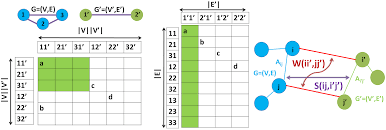</center>
<center> Figure 2: Example of matching compatibility matrix $W$ and edge similarity matrix $S$. Source: Cour et al. (2005). </center>


## Benchmark algorithms

### SDP relaxation

SDP relaxation applied to graph matching is proposed by Schellewald et al. in "Probabilistic subgraph matching based on convex relaxation" (2005). The goal here is to make the objective  and the constraints convex through the introduction of semi-definite positive matrices. Namely, the first step of SDP relaxation is to rewrite the objective as an matrix inner product: 
$$x^\top W x = \langle X, W_{eq} \rangle_F = \text{Tr}(W_{eq}^\top X)$$ where
X = $$
\left( \begin{array}{cc}
1  \\
x 
\end{array} \right)
%
\left( \begin{array}{cc}
1 & x^\top \\
\end{array} \right)
= \left( \begin{array}{cc}
1 & x^\top \\
x & xx^\top
\end{array} \right)$$ and  $$W_{eq} = \left( \begin{array}{cc}
0 & d^\top /2 \\
d/2 & W-D 
\end{array} \right) = W_{eq}^\top$$ where $d=\text{diag}(W)$ and $D$ is a diagonal matrix with diagonal $d$. The following formulation can be rapidly check as: 
$$ \text{Tr}(W_{eq}^\top X) = \text{Tr}(W_{eq} X) = \text{Tr}\left( \begin{array}{cc}
d^\top x/2& d^\top xx^\top /2  \\
d/2 + (W-D)x & dx^\top /2 + (W-D)xx^\top
\end{array} \right)$$ The previous expression is then equal to:
$$\text{Tr}(dx^\top) + \text{Tr}(x^\top W x) - \text{Tr}(x^\top D x)$ = x^\top W x - \displaystyle \sum_i^{nn'} d_i(x_i-x_i^2)$$ using commutativity of the trace. At last, one may remark that $x$ being an integer vector, $x_i^2=x_i \, \forall \, i$ so it shows that the SDP relaxation is valid. 
Now, besides being symmetric, the matrix $X$ is positive semidefinite with rank $1$. SDP relaxation relax the rank $1$ non-convex condition in order to only require that $X$ is positive semi-definite. Thus, program $(4)$ now becomes:
\begin{equation}
\tag{SDP}
    \max_{X} \text{Tr}(W_{eq} X) \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} X \succeq 0 \hspace{0.5cm} \text{and} \hspace{0.5cm} (\star)
\end{equation} where now the set of $X$ is the set of psd matrices which is convex (it can be shown using the basic property of convexity). Nevertheless, we still need to treat the constraints $(\star)$ and incorporate the latter into the SDP relaxation by specifying appropriate constraint matrices. We wish thos SDP constraints to have the form:
$$\text{Tr}(C_{eq}^{(i)} X) \leq b_{eq}^{(i)} $$ for suitable $C_{eq}^{(i)} $ and $b_{eq}^{(i)}$. 


*   First, we have to deal with the first constraint that results from the homogeneization of the problem, namely, the first element of $X$ equal $1$ : $X_{11}=1$. This can be expressed as:
$$C_{eq, kl}^{(1)} = \delta_{k1}\delta_{l1} \hspace{0.5cm} \text{for} \hspace{0.5cm}  k, l = 1,..., nn'+1$$ and $$b_{eq}^{(1)} = 1$$


*   The second constraint is derived from the integer constraints $x_i \in \{0,1\}, i=1,..., nn'+1$, which can be rewritten as $x_i^2=x_i$. Therefore, the elements on the diagonal of $X$ are equal to the ones in the first column and row of $X$ (this can be easily seen by just writting $X$). The consequence of this observation is that the 0/1 integer constraint can be enforced in the relaxed problem by requiring the first column and row of $X$ to be equal to its diagonal. To do so, one may follow closely the article from Schellewald (2005). The authors propose to introduce $nn'$ constraint matrices $C_{eq}^{(j)}$ for $j=2,...,nn'+1$ whose elements verify:
$$C_{eq, kl}^{(j)} = 2 \delta_{kj} \delta_{lj} - \delta_{kj} \delta_{l1} - \delta_{lj} \delta_{k1} \hspace{0.5cm} \text{for} \hspace{0.5cm} k,l=1,...,nn'+1$$
These matrices have thus a $2$ at the corresponding $j$-th diagonal and $-1$ at the corresponding elements in the first column and the first row. And zeros everywhere else. Then, $\text{Tr}(C_{eq}^{(j)} X) = 2(x_j^2-x_j)$ which, to fit the 0/1 integer constraints, has to be equal to $0$. Hence, 
$$b_{eq}^{(j)} =0$$
 

* The third constraint to take into account comes from the mapping constraints. Namely, we should have that $\displaystyle \sum_{i=1}^n x_{i'i}=1$ for all $i'=1,...,n'$. To recall, these constraint represent the fact that each node of the bigger graph (here we take $G'$) is mapped to exactly one node of $G$, the smaller graph here. We need once again to exploit the fact that $x_i=x_i^2$. Indeed, our previous condition can be written as $\displaystyle \sum_{i=1}^n x_{ii'}^2=1$ for all $i'=1,...,n'$. Thus, the intuition is that, for a given $i'$, we should multiply the diagonal elements $x_{ii'}^2$ from matrix $X$ by one and then force the sum to be equal to $1$. More formally, if we set $C_{eq}^{(j)}$ for $j=1,...,n'$ such that:
$$C_{eq, kl}^{(j)} = \displaystyle \sum_{i=(j-1)n+1}^{jn+1} \delta_{ik} \delta_{il} \hspace{0.5cm} \text{for} \hspace{0.5cm} k,l=1,...,nn'+1$$ and $$b_{eq}^{(j)}=1$$ Then $\text{Tr}(C_{eq}^{(j)}X)=b_{eq}^{(j)}$ is equivalent to the original condition. 

* The fourth constraint is relative to the one-to-many constraints. Namely, we should also have that $\displaystyle \sum_{i'=1}^{n'} x_{ii'} \geq 1$ for all $i=1,...,n$. It means that one vertex of the smaller graph (say $G$) can map at least one vertex of $G'$. The reasoning is quite similar to the previous one, except that now we will require the diagonal elements separated by $n'$ elements to sum to $1$. More formally, if we set $C_{eq}^{(j)}$ for $j=1,...,n$ such that:
$$C_{eq, kl}^{(j)} = \displaystyle \sum_{i=1}^{n'+1} \delta_{(i-1)n'+j,k} \delta_{(i-1)n'+j,l} \hspace{0.5cm} \text{for} \hspace{0.5cm} k,l=1,...,nn'+1$$ and $$b_{eq}^{(j)}=1$$ Then $\text{Tr}(C_{eq}^{(j)}X) \geq b_{eq}^{(j)}$ is equivalent to the original condition. 

* The last condition, $\displaystyle \sum_{i'=1}^{n'} x_{ii'} \leq K$ for all $i=1,...,n$ uses the negation of the same constraint matrices as above such that: 
$C_{eq}^{(j)}$ for $j=1,...,n$ such that:
$$C_{eq, kl}^{(j)} = - \displaystyle \sum_{i=1}^{n'+1} \delta_{(i-1)n'+j,k} \delta_{(i-1)n'+j,l} \hspace{0.5cm} \text{for} \hspace{0.5cm} k,l=1,...,nn'+1$$ and $$b_{eq}^{(j)}=-K$$ Then $\text{Tr}(C_{eq}^{(j)}X) = - \text{Tr}(-C_{eq}^{(j)}X) \geq b_{eq}^{(j)}=-K$ is equivalent to the original condition by multiplying this inequality by $-1$. 

As a conclusion, the SDP relaxation introduces $1+nn'+n'+2n=(1+n)(1+n')+n:=k$ convex constraints in addition to $X \succeq 0$. Finally, the relaxed program becomes:
\begin{equation}
\tag{SDP}
    \max_{X} \text{Tr}(W_{eq} X) \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} X \succeq 0 \hspace{0.5cm} \text{and} \hspace{0.5cm}\text{Tr}(C_{eq}^{(i)} X) \leq b_{eq}^{(i)} \, \, \text{for} \, \, i=1,...,k
\end{equation} and $k$ the number of constraints.

### Gradiated Assignment (GA)

The graduated assignment technique for one-to-many graph matching problems has been originally proposed by Gold et al. in "A graduated assignment algorithm for graph matching" (1996). Here, the term assignment refers to a correspondence between one set of objects and another. Precisely, an element from matrix $M$ (or vector $x$) is equal to $1$if one set is assigned to (or corresponds to) a given object in the other set. This algorithm will be particularly useful for our implementation and may require a specific attention. Gold et al. (1996) problem formulation is part of *weigthed graph matching* problems. Problem $(4)$ remains unchanged as for the mapping constraints. 

The authors first recall that the main difficulty of graph matching problem is to satisfy the two-way (or more for one-to-many matching) mapping constraints. First, they ignore the inequality constraints so that the constraint is equivalent to $M$ being a permutation matrix. Indeed, we restrict ourselves to one-to-one matching. This implies that  A permutation matrix is such that it is binary and whose rows and columns add up to one. In other words, we first ignore the slack variables which aim at shifting the inequality constraints to equality constraints. Namely, ... 


<center><img src="https://csdl-images.computer.org/trans/tp/1996/04/figures/i03772.gif"  width="150" ></center>
<center> Figure 3: matrix $M$ with slack variables, equivalent to $x$ being reshape into matrix of size $n\times n'$. Source: Gold et al. (1996)</center>





We provide below a simple implementation of Graduated Assignment for one to one matching. As we only have equality constraints we do not need to add slack variables here.

Note that we do not take advantage of the sparsity here using matrix products instead of computing the gradient and the objective only with the non-zeros values. We choose this formulation for the sake of simplicity as we will only test our function on basic examples where the code is still fast.

In [5]:
def GA_matrix(W, n, x0, b0=0.5, bf=10., br=1.075,
              tol0=0.5, tol1=0.05, itermax0=30, itermax1=30, display_step=False):
    """
    :param W: Compatibility matrix
    :param n: size the graphs
    :param x0: starting assignment
    :param b0: starting control parameter
    :param bf: upper value of the control parameter
    :param br: increase rate for the control parameter
    :param tol0: tolerance for convergence of the gradient descent on bistochastic x
    :param tol1: tolerance for bistochastic normalization of x
    :param itermax0: maximal number of iterations for the gradient descent on bistochastic x
    :param itermax1: maximal number of iterations for a single normalization
    :param display_step: show x for each control parameter
    :return: bistochastic approximation of the solution of 1 to 1 matching
    """
    beta, x = b0, x0
    while beta < bf:
        err, n_iter = np.inf, 0
        while err > tol0 and n_iter < itermax0:
            prev_x = copy(x)
            Q = np.dot(W, x)
            x = np.exp(beta*Q)
            err1, n_iter1 = np.inf, 0
            x = x.reshape((n, n))
            while n_iter1 < itermax1 and err1 > tol1:
                prev_x1 = copy(x)
                x = np.apply_along_axis(lambda y: y/y.sum(), 0, x)
                x = np.apply_along_axis(lambda y: y/y.sum(), 1, x)
                err1 = np.sum(np.abs(x-prev_x1)**2)
                n_iter1 += 1
            x = x.flatten()
            x = np.round(x, 6)
            err = np.sum(np.abs(x-prev_x)**2)
            n_iter += 1
        beta *= br
        if display_step:
            print('beta {}'.format(beta))
            print(x.reshape((n, n)))
    return np.round(x, 3)


### Spectral Matching (SM)

This last relaxation method is based on the work of Leordeanu et al., "A Spectral Technique for Correspondence Problems Using Pairwise Constraints" (2005). It has the particularity to relax the mapping constraints and the integral constraints on $x$, such that the optimization problem becomes:
\begin{equation}
\tag{SM}
R(x) = x^\top W x \hspace{1cm} \text{s.t.} \hspace{1cm} \|x\|^2 = 1
\end{equation}
We see that $R(x) = R(cx)$ with $c$ a scalar. Thus, $R$, called the Rayleigh quotient, is invariant by translation, which allows to just study the special case $\|x\|^2=x^\top x = 1$. Writing the Lagrangian of the program above leads to solving $Wx=\lambda x$ with $\lambda$ the Lagrange multiplier. Thus, the critical points of the Rayleigh quotient are the eigenvectors of $W$ with their corresponding eigenvalues. Thus, there could be multiple stationary points for the solution to exist. However, $W$ being non-negative elementwise, we can make use of the Perron-Frobenius theorem. First, let's recall that the elements of $W$, $W_{ii',jj'}=f(A_{ij},A_{i'j'}')$ are taken non-negative in both articles. In Cour et al. experiments, $W_{ii',jj'}=\exp(-|A_{ij}-A_{i'j'}'|^2) > 0$ $\forall \, ij \in E, i'j' \in E'$. This allows to apply Perron-Frobenius theorem which has important applications to graph theory. This theorem applies to positive matrices but generalizes to non-negative ones, which is correct here. It states that if $W$ has non-negative entries, then it has a nonnegative real eigenvalue $\lambda$ which has maximum absolute value among all eigenvalues. This eigenvalue $\lambda$ has a nonnegative real eigenvector. If we rewrite $R$ evaluated to one of its critical points $x^*$, then $R(x^*)=x^{*^\top}Wx^* = x^{*^\top} \lambda^ *x^* = \lambda$. From Perron-Frobenius theorem, we know that their exist a unique eigenvalue of $W$, nonnegative, which dominates the other and whom corresponding eigenvector is nonnegative too. Thus, program (SM) can be solved by computing the leading eigenvector, or Perron eigenvector of $W$. As $x^*$ is nonnegative and $\|x^*\|^2=1$, then the elements of $x^*$ necessarily lie in the interval $[0,1]$. Leordeanu et al. (2005) argue that their spectral matching method benefits from an important computational gain. The latter coming from the removal of both the mapping constraints and the integral constraints during the optimization step. Those constraints are then incorporated only afterwards during the binarization of the eigenvector. 






The spectral Matching algorithm is pretty straightforward to implement. Note that the numpy eigensolver can be quite unstable in some situations. In our results we could check that this is not necessarily a problem: the leading eigenvector estimation seem quite accurate in most cases.

In [6]:
def SM(W):
    """
    :param W: affinity matrix
    :return: leading eigenvector of W if W is non-negative
    """
    l, v = eigh(W)
    v = np.round(v, 6)
    s = v.sum(axis=0)
    for i in range(v.shape[1]):  #remove spurious results
        if s[i] == 0:
            l[i] = 0
    lead_ind = np.argmax(l)
    lead_ev = v[:, lead_ind]
    return np.abs(lead_ev)

## Spectral Matching with Affine Constraint (SMAC)

As we said, the first contribution of the authors is to propose a new algorithm, *Spectral Matching with Affine Constraint*. This algorithm is inspired from spectral matching but allows to impose affine constraints $Cx=b$ on the relaxed solution before the discretization step instead of dropping it. Thus, SMAC benefits from the scalability and speed of SM and may provide more effective solution to the graph matching problem through the ability to maintain this constraint. SMAC algorithm solve the following optimization program:
\begin{equation}
\tag{5}
    \max_x \frac{x^{\top}Wx}{x^{\top}x} \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} Cx=b
\end{equation}
where $Cx=b$ will be made explicit just after. 


### Computational solution


The authors define problem (5) as a *Rayleigh Quotient under Affine Constraint* , i.e. a generalization of Rayleigh Quotient:

\begin{equation}
\tag{6}
    \max_x \epsilon_1(x) = \frac{x^{\top}Ax}{x^{\top}Bx} \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} Cx=b
\end{equation} with $x \in \mathbb{R}^p, b\in \mathbb{R}^k, B \succ 0, C \in \mathbb{R}^{k\times p}$ of full rank with $k<n$. This part aims at detailing the computation of the solution.

The first step is to transform the affine constraint into a linear constraint $C_{eq}x=0$. We take the particular case $B=I$ in order to fit to our problem (for the general case, we should consider $y=B^{-1/2}x$ to get rid of matrix $B$). Problem $(6)$ is equivalent to:
\begin{equation}
\tag{7}
    \max_{z, t} \epsilon_2(z, t) = \frac{z^{\top}Az}{z^{\top}z} \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} Cz=tb
\end{equation} where $t \in \mathbb{R}$. Indeed, $(z^*, t^*)$ is an optimum of $(7)$ if and only if $x^* = (1/t^*)z^*$ is an optimum of $(6)$. In the case where $t^*=0$, problem $(6)$ has no solution whereas $(7)$ has one. From now on, we suppose that $t^* \neq 0$. Then, the authors describe three different methods to solve $(7)$. We consider the third one, which is the most computationally efficient (and the one chosen in the article).


Let $b_k$ be the last coefficient of vector $b$ and $k$ the number of constraints. We assume without loss of generality that $b_k \neq 0$ (otherwise we can reorder the rows of $C$ and $b$). The key basis of the method lies in the following equivalence:


$$\Big[\exists t \, : \, Cz = tb \Big] \Longleftrightarrow \Big[ \forall i \, \in \, [1, k-1], (Cz)_i = (1/b_k)(Cz)_kb_i \Big]$$

Indeed, $t=(Cz)_i / b_i = (Cz)_k / b_k \, \, \forall \, i \, \in \, [1, k-1]$. Then, for all $i \, \in \, [1, k-1]$,  
\begin{eqnarray}
& \displaystyle \sum_{\ell} C_{i\ell}z_\ell - \frac{1}{b_k} \displaystyle \sum_\ell C_{k\ell}z_\ell b_i & =  0 \\
\Longleftrightarrow & \displaystyle \sum_{\ell} \Bigg( C_{i\ell}z_\ell - \frac{1}{b_k} C_{k\ell} b_i \Bigg) z_\ell &= 0 \\
\tag{8}
\Longleftrightarrow & \Big(C_i - \frac{1}{b_k} C_k b_i\Big) z &= 0 
\end{eqnarray}
Now, if we set $J=[I_{k-1} \,; 0] \in \mathcal{M}^{k-1 \times k}$ (i.e. the canonical projector $\mathbb{R}^k \rightarrow \mathbb{R}^{k-1}$), the previous equation is equivalent to:
\begin{equation}
    J(C-(1/b_k)bC_k)z = C_{eq}z=0
\end{equation} where $C_k$ is the last row of $C$. Indeed, the sub-product $I_{k-1} \cdot \Big(C-(1/b_k)bC_k\Big)$ represents the previous conditions $(8)$. $C_{eq}$ now defines the new linear constraint matrix. 

___
Therefore, problem $(5)$ can be rewritten as:
\begin{equation}
\tag{9}
    \max_x x^{\top}Wx \hspace{0.5cm} \text{s.t.} \hspace{0.5cm} C_{eq}x=0, \hspace{0.5cm} x^{\top}x = ||x||^2 = 1
\end{equation}
due to the invariance by translation of the Rayleigh Quotient.
___

The Lagrangian associated with $(9)$ is as follows: $$\mathcal{L}(x; \lambda, \mu) = x^{\top}Wx + \lambda(1-||x||^2) + \mu^{\top}(-C_{eq}x)$$ Hence, 


\begin{array}{cccl}
     & \nabla_x \mathcal{L}(x; \lambda, \mu) &=& 2Wx - 2\lambda x - \mu^{\top}C_{eq} = 0 \\
     \Longleftrightarrow &  2Wx &=& 2\lambda x + C_{eq}^{\top} \mu \\
     \Longleftrightarrow &  2C_{eq}Wx &=& 2\lambda C_{eq} x + C_{eq}C_{eq}^{\top} \mu \\
     \Longleftrightarrow &  \mu &=& \big( C_{eq}C_{eq}^{\top} \big)^{-1} \big( 2C_{eq}Wx - 2\lambda  C_{eq} x \big) \\
     \Longrightarrow & 2Wx &=& 2\lambda x + 2C_{eq}^{\top} \big(C_{eq}C_{eq}^{\top} \big)^{-1} C_{eq}\Big(Wx -\lambda x \Big) \\
     \Longleftrightarrow & Wx - C_{eq}^{\top} \big(C_{eq}C_{eq}^{\top} \big)^{-1} C_{eq}Wx &=& \lambda x - C_{eq}^{\top} \big(C_{eq}C_{eq}^{\top} \big)^{-1} C_{eq} \lambda x \\
     \Longleftrightarrow & (I-C_{eq}^{\top} \big(C_{eq}C_{eq}^{\top} \big)^{-1} C_{eq})Wx &=& \lambda (I-C_{eq}^{\top} \big(C_{eq}C_{eq}^{\top} \big)^{-1} C_{eq})x \\
     \Longleftrightarrow & P_C W x &:=& \lambda P_C x
\end{array}

From these derivations yield the final result that the solution of $(5)$ is  given by the leading eigenpair of 
\begin{equation}
    P_CWP_Cx = \lambda x 
\end{equation} as $P_Cx=x$ since $x$ verifies the linear constraint $C_{eq}x=0$. Here again, we use Perron-Frobenius theorem 

The implementation of the SMAC basically consists in computing the matrix $P_c$ and reusing our implementation of the Spectral Matching algorithm.

In [7]:
def get_Pc_SMAC(C, b):
    """
    :param C: Constraints matrix
    :param b: value of each constrain
    :return: Modified matrix Pc, as defined in Cour et al 
    """
    k = C.shape[0]
    Ik = np.zeros((k-1, k))
    Ik[:, :-1] = np.eye(k-1)
    for i in range(k):
        C[i] = C[i] - b[i]/b[-1]*C[-1]
    Ceq = np.dot(Ik, C)
    inv_C = np.linalg.inv(np.dot(Ceq, Ceq.T))
    all_C = np.dot(Ceq.T, np.dot(inv_C, Ceq))
    return np.eye(C.shape[1])-all_C
  
  
def SMAC(W, Pc):
    """
    :param W: Compatibility Matrix
    :param Pc: Matrix obtained by transforming the constraint matrix, according to the paper
    :return: leading eigenvector of Pc*W*Pc
    """
    new_W = np.dot(Pc, np.dot(W, Pc))
    return SM(new_W)


### Discretization

SMAC is based on a continuous relaxation of the IQP. As such, a post-processing step is needed to discretize the continuous solution while satisfying the desired constraints. If we reshape the solution $x$ into a $n\times n'$ matrix, then the constraints in $(4)$ can be rewritten as :
\begin{equation}
    X \mathbf{1_{n'}} = \mathbf{1_{n'}}, \hspace{1cm} X^{\top} \mathbf{1_n} = \mathbf{1_{n}}, \hspace{1cm} X \in \mathcal{O}(n,n'), \hspace{1cm} X \geq 0 \, \text{ elementwise}
\end{equation} where $\mathbf{1_n}$ and $\mathbf{1_{n'}}$ correspond to the constant $n$ and $n'$ dimensional vectors of all ones respectively. Let's assume now that $n=n'$. Then, one can remark that the previous constraints can be summarised by \textbf{"$X$ belongs to the set of permutation matrices"} whose convex hull is the set of bistochastic matrices, where the the constraint $X \in \{0,1\}^{n\times n}$ is replaced by $X \in [0,1]^{n\times n}$. The authors propose to incorporate the first $3$ constraints (out of $4$)  as a post-processing step before the final discretisation. Let's focus on it through the general case where $n \neq n'$. \newline

### Reshape

The first step is to reshape the continuous solution $x$ into a $n\times n'$ matrix $X$. 

### Orthogonal approximation

Then, one should compute the best orthogonal approximation $X_{orth}$ of $X$: 

 \begin{eqnarray}
    X_{orth} &=& \operatorname{argmin}_Q\{\|X-Q\|_F : Q \in O(n,n')\}
 \end{eqnarray}
 
 This can be done using the Singular Value Decomposition (SVD) of $X$, namely $X=U\Sigma V^{\top}$ where $U$ and $V$ are $2$ orthogonal matrices, $U \in O(n), V \in O(n'), \Sigma \in \mathbb{R}^{n \times n'}$. If we denote $p$ as $p=\min(n,n')$, then $\Sigma = \text{diag}(\sigma_1,...,\sigma_p, 0, ..., 0)$ where $\sigma_1,...,\sigma_p$ are the singular values of $Q$ and are positive. We should show now the following key result from Procrustes theory applied to the strategy of discretization:
\begin{eqnarray}
 X_{orth} = UV^\top
\end{eqnarray}


\hspace{-0.7cm} First, let's notice that 
 $$X_{orth} = \operatorname{argmin}_Q\{\|X-Q\|_F : Q \in O(n,n')\} = \operatorname{argmin}_Q\{\|X-Q\|^2_F : Q \in O(n,n')\}$$
 Using the distributivity of the inner product (w.r.t to the Frobenius norm):
\begin{equation}
\begin{array}{ccl}
    \|X-Q\|^2_F &=& \langle X-Q,X-Q \rangle_F\\
    & = & \|X\|^2_F + \|Q\|^2_F - 2 \langle X, Q \rangle_F
\end{array}
\end{equation}
With $$ \|Q\|^2_F = \text{Tr}(Q^{\top} Q) = \text{Tr}(I_{n'\times n'}) = n'$$ As the sum $\|X\|^2_F + n'$ does not depend on $Q$, the optimization problem can be simplified as follows:
\begin{equation}
\begin{array}{ccl}
    Q^* = \operatorname*{argmax}\limits_{Q \in O(n, n')} \langle X, Q \rangle_F
\end{array}
\end{equation}
Now we can introduce the Singular-Value Decomposition of $X=U\Sigma V^T$. 
\begin{equation}
\begin{array}{ccl}
    Q^* = \operatorname*{argmax}\limits_{Q \in O(n, n')} \langle Q, X \rangle_F = \operatorname*{argmax}\limits_{Q \in O(n, n')} \langle Q, U\Sigma V^T \rangle_F
\end{array}
\end{equation}
where $U \in O(n), V \in O(n'), \Sigma \in \mathbb{R}^{n \times n'}$. If we denote $p$ as $p=\min(n,n')$, then $\Sigma = \text{diag}(\sigma_1,...,\sigma_p, 0, ..., 0)$ where $\sigma_1,...,\sigma_p$ are the singular values of $Q$. Now, using basic properties of the trace we have that:
\begin{equation*}
\begin{array}{ccl}
    \langle Q, U\Sigma V^T \rangle_F &=& \mbox{Tr}([Q^{\top}U][\Sigma V^{\top}]) \\
    &=& \mbox{Tr}([\Sigma][V^{\top} Q^{\top} U]) \\
    &=& \mbox{Tr}(V^{\top} Q^{\top}U\Sigma) \\
    &=& \mbox{Tr}((U^{\top}QV)^{\top}\Sigma) \\
    &:=& \mbox{Tr}(Z^{\top}\Sigma) \\
    &=& \displaystyle \sum_{i=1}^p Z_{ii} \sigma_i 
\end{array}
\end{equation*}
As $Z:=U^{\top}QV$ is a product of orthogonal matrix, it is still an $(n, n')$-dimensional rectangular orthogonal matrix whose rows' coefficients (or columns' coefficients) sum to 1 if $n \leq n'$ (or $n' \leq n$, due to linear dependence). So in any case $Z_{ii}\leq1 \, \forall \, i \in \{1,...,p\}$. As maximizing in $Q$ is equivalent to maximizing in $Z$ (as $Z$ is a linear transformation of $Q$), we have that our final expression is maximal if and only if $Z_{ii}=1\, \forall \, i=1,...,p$, that is to say $Z^{*}= U^{\top}Q^*V= [I_{p\times p}, 0]$ (if $n \leq n'$, otherwise $[I_{p\times p}, 0]^T)$. Which prooves that $Q^* = UV^{\top}$. \color{red} Conclusion à finir \color{black}

### Affine constraint

\hspace{-0.7cm} Let's suppose that $u$ is left and right eigenvector of $X$. Hence, $u$ is an eigenvector of $X$ and $X^\top$. Simple calculation allows to show that $u$ is then an eigenvector of both $XX^\top$ and $X^\top X$. By construction of the Singular Value Decomposition, the columns of $U$ are the eigenvectors of $XX^\top$ and the columns of $V$ are the eigenvectors of $X^\top X$. Then, $u$ is a column in $U$ and in $V$. Namely, $u$ is a left and right singular vector of $X$. Therefore, all other singular vectors in $U$ and $V$ are orthogonal to $u$. It yields $UV^\top u = \|u\|^2 \cdot u$ and so $X_{orth} u = \|u\|^2 \cdot u$ as $X_{orth}$ is orthogonal. Reversely, we can show that $X_{orth} u = \|u\|^2 \cdot u$. Hence, $u$ is left and right eigenvector of $X_orth$. Since $X_{orth}$ is orthogonal, $\|u\|^2=1$. Now, as $X$ verifies the $4$ constraints,  $\mathbf{1}_n$ is a left and right eigenvector of $X$, and hence of $X_{orth}$. Finally, $X_{orth} \mathbf{1}_n = \mathbf{1}_n$ and $X_{orth}^\top \mathbf{1}_n = \mathbf{1}_n$.

## Discretization step 

As the algorithms we studied use continuous relaxation to propose a solution of our Integer Quadratic Problem, a supplementary step is necessary to convert this solution into an acceptable one. This means that we need to reintroduce the constraints and to provide a binary output.

Now let's consider that our output is a $n\times n'$ matrix (by reshaping it). For one to one matching, these constraints just imply that our output $n \times n$ output must be a permutation matrix. This step can be handled with a simple 2 step procedure:

* Run Graduated Assignment using the output of the first algorithm as the starter. If the algorithm is successful then the output should be transformed into a bistochastic matrix. This is very interesting a each row/column of the matrix can be interpreted as a marginal probability of one vertice of the first/second graph with the vertices of the other graphs.

* If the output of GA is not a permutation matrix, run a new procedure based on a probability interpretation of the coefficients of the matrix. This procedure can either be greedy or randomized. We implemented different procedure introduced in  the paper cited by Cour et al.

For this second step, a naive approach is a greedy selection of the coefficients that will be set to one: if a coefficient $x_{ij}$ is both the maximum of its row and column, then the matching $(i,  j)$ is the most probable for both vertices and hence it is reasonable to integrate it in our final solution.
Unfortunately, this approach is often not sufficient to provide all assignments and it need to be completed with other tests. To this extent, we implemented a randomized procedure for the left vertices based on a simple sampling algorithm:
* Draw uniformly at random one of the left vertices $i$ of the first graph
* Extract the raw $x_i$, set the value of the already assigned elements $j$ of the second graph to zero and normalize the raw to get a probability vector $p_i$ of size $n$.
* Draw a vertice $j$ with probability $p_i(j)$ and set $x_{ij}=1$ and $x_{i'j}=x_{ij'}=0$ for all others $i', j'$.
* Restart the procedure while $x$ is not a permutation matrix

We tested this procedure, which seems to provide good results. Our implementation is below. Actually, Cour et al. used another greedy procedure in their experiments QUE JE DETAILLERAI ET IMPLEMENTERAI SI J'AI LE TEMPS.

In [9]:
def discretize_one_to_one(W, n, x_res, is_GA=False, n_sampling = 100):
    """
    :param W: Affinity matrix
    :param x: Result from the first algorithm
    :param is_GA: True if the first algorithm is Graduated Assignment
    :return: Discretized solution for one to one matching (i.e a Permutation Matrix)
    """
    if not is_GA:
        x = GA_matrix(W, n, x0=x_res)
    else:
        x = copy(x_res)

    # Check if the solution is already a permutation matrix
    row_sum = np.dot(x.reshape((n, n)), np.ones(n))
    col_sum = np.dot(x.reshape((n, n)).T, np.ones(n))
    diff_row, diff_col = row_sum - np.ones(n), col_sum - np.ones(n)
    if np.abs(diff_row).sum() == 0 and np.abs(diff_col).sum() == 0:
        print('Output of GA is already permutation matrix')
        return x

    # Greedy procedure: if the max on rows is the max on columns then this permutation is in the solution
    x = x.reshape((n, n))
    max_row = np.argmax(x, axis=1)
    max_col = np.argmax(x, axis=0)
    row_solution = np.zeros((n, n))
    col_solution = np.zeros((n, n))
    for i in range(n):
        row_solution[i, max_row[i]] = 1
        col_solution[max_col[i], i] = 1
    diff = np.abs(row_solution-col_solution).sum()
    if diff == 0:
        print('Greedy procedure successful: no conflict between rows and columns')
        return row_solution.flatten()

    # Randomized method based on Sampling for left vertices

    X = row_solution*col_solution
    unfilled_row = np.where(X.sum(axis=1) == 0)[0]
    unfilled_col = np.where(X.sum(axis=0) == 0)[0]
    if unfilled_row.shape[0] == 1:
        X[unfilled_row[0], unfilled_row[0]] = 1
        return X.flatten()

    prob = x[unfilled_row][:, unfilled_col]
    prob = np.apply_along_axis(lambda x: x/x.sum(), 1, prob)
    r = np.arange(len(unfilled_row))
    c = np.arange(len(unfilled_col))

    current_obj = -np.inf
    for k in range(n_sampling):
        new_X = copy(X)
        proba_row = np.ones(len(unfilled_row))/len(unfilled_row)
        p = copy(prob)
        res_r = []
        res_c = []
        for i in range(len(r)):
            new_r = np.random.choice(r, p=proba_row)
            new_c = np.random.choice(c, p=p[new_r])
            res_r.append(new_r)
            res_c.append(new_c)
            proba_row[new_r] = 0
            proba_row = proba_row/proba_row.sum()
            p[:, new_c] = 0
            p = np.apply_along_axis(lambda x: x/x.sum(), 1, p)

        for i in range(len(unfilled_row)):
            new_X[unfilled_row[res_r[i]], unfilled_col[res_c[i]]] = 1
        new_x = new_X.flatten()
        new_obj = np.dot(new_x.T, np.dot(W, new_x))
        if new_obj > current_obj:
            x = new_x
            current_obj = new_obj
    return x

## Computational cost

## Bistochastic normalization

The second contribution of this article is called bistochastic normalization. Before giving more detailed information about this method, let's see the motivations and intuitions from which arise the need for normalization of the compatibility matrix $W$. To illustrate the need for some normalization of $W$, the authors consider 2 examples. The first one is the result of SMAC runs on real images. More precisely, they extract a set of feature points in two airplane images and, for each edge of plane 2 (top-right), plot the most similar edges on plane 1 (top-left). Blue arrows indicate edges with high similarity. We can notice 2 main groups of edges: 
* edges of type "1": they correspond to roughly horizontal edges in th 2 images. Horizontal edge $e$  (zoom on bottom-left image) from plane 2 has many correspondances with edges in plane 1. This edge is described as an *uninformative* edge as it can not be used to match a precise and restricted set of edges. 
* edges of type "2": on the contrary, those edges are considered as *informative*. They roughly correspond to informative or *distinctive* edges. Indeed, most similar edges (blue arrows in plane 1, bottom-right corner) are grouped in approximately 5 distant locations. 
Despite this clear distinction, informative edges contribution are "outweighted" by uninformative ones. This is due to the fact that $W$ is unbalanced.



<center><img src="
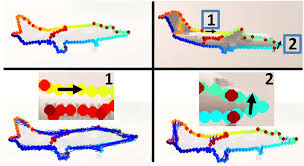"  width="350" ></center>
<center> Figure 5: Examples of matching cliques. Source: Cour et al. (2005). </center>


To illustrate a bit more the idea of imbalance in the structure of $W$, we reproduced the synthetic noise model example of the article from Cour et al. (2005) (figure 2 in the article). The following piece of code aims at implementing the Bistochastic Normalization. Without any further details yet, let's explain the benefit from the method through this simple example below. 

Defining 2 isomorphic graphs with 3 nodes...



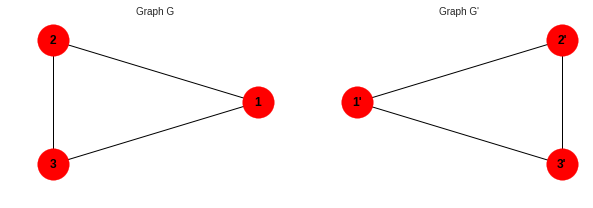


Normalization...
Time elapsed: 0.067 seconds



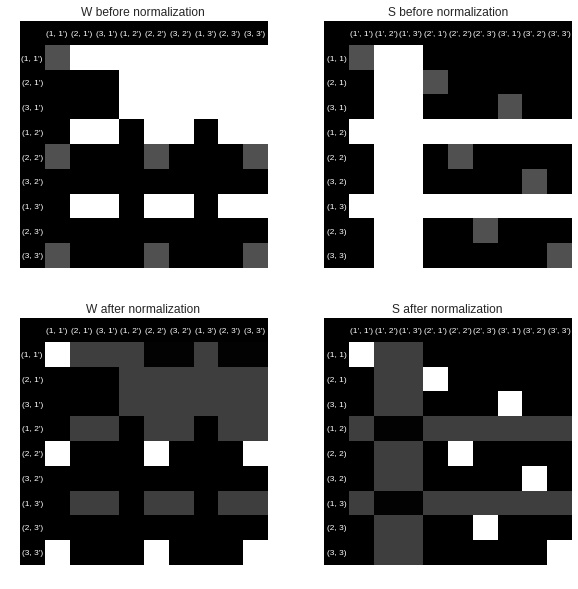

In [0]:
######################Synthetic noise model example#############################
# First, we import packages of interest for this example
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import view_as_blocks
import networkx as nx
from copy import copy
import warnings
import time
warnings.filterwarnings('ignore')

################################################################################

# We create a synthetic function to display graph using networkx package
def getGraph(nodes, edges, positions):
    """
    :param nodes     : list, labels of nodes
    :param edges     : list, list of tuples. A tuple represent any connection (undirected graph).
    :param positions : list of tuples, (x, y) coordinates of nodes
    """
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    G = G.to_undirected()
    pos = {}
    for i, n in enumerate(nodes):
      pos[n] = positions[i]
    nx.draw(G, pos=pos, with_labels=True, font_weight='bold', node_size=1e3)

# We display the 2 graphs of figure 2 (article)
print('Defining 2 isomorphic graphs with 3 nodes...\n')
edges_G1 = [['1', '2'], ['1', '3'], ['2', '3']]
edges_G2 = [["1'", "2'"], ["1'", "3'"], ["2'", "3'"]]
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
getGraph(['1', '2', '3'], edges_G1, positions=[(2, 1), (1, 1.5), (1, 0.5)])
plt.title('Graph G', fontsize=10)
plt.subplot(1, 2, 2)
getGraph(["1'", "2'", "3'"], edges_G2, positions=[(0, 1), (1, 1.5), (1, 0.5)])
plt.title("Graph G'", fontsize=10)
plt.show()
    
################################################################################

t = time.time()
print('\nNormalization...')
# Then, we define W_b as a proxy of matrix W inspired from the gray colorscale
# from middle image of figure 2 (Cour et al., 2005)
W_b = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0.25, 1, 1, 1, 1, 1, 1, 1, 1],
                [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
                [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
                [0, 0, 1, 1, 0, 1, 1, 0, 1, 1],
                [0, 0.25, 0, 0, 0, 0.25, 0, 0, 0, 0.25],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 1, 0, 1, 1, 0, 1, 1],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0.25, 0, 0, 0, 0.25, 0, 0, 0, 0.25]])

# Now, we briefly define a method to transform W to S
def WtoS(W, n1, n2):
  """
  Transform compatibility matrix W to similarity matrix S
  :param W  : np.array, compatibility matrix
  :param n1 : np.array, number of vertices in first graph
  :param n2 : np.array, number of vertices in second graph
  :return   : np.array, similarity matrix S
  """
  blocks = view_as_blocks(W,  block_shape=(n1, n1))
  S = np.zeros((n1**2, n2**2))
  for j in range(n2**2):
        S[:, j] = blocks[j//n2, j % n2].flatten('F')
  return S

# Then, we apply it on W_b
S_b = WtoS(W_b[:, 1:10][1:10], 3, 3)
S_b = np.c_[np.zeros(S_b.shape[0]), S_b]    
S_b = np.r_[[np.zeros(S_b.shape[1])], S_b]

# Before implementing bistochastic normalization, we use norm_check
# method
def norm_check(x):
  """
  """
  s = np.abs(x).sum()
  if s > 0:
    return x/s
  else:
    return x
      
def bistochastic_normalization(W, n1, n2, max_iter=100, tol=1e-4):
  """
  Implement Bistochastic Normalization as described in section 5.2 in Cour et al. (2005)
  :param W        : np.array, compatibility matrix
  :param n1       : np.array, number of vertices in first graph
  :param n2       : np.array, number of vertices in second graph
  :param max_iter : int, maximal number of iterations (stopping criteria n°1) 
  :param tol      : float, precision threshold (stopping criteria n°2) 
  :return         : np.array, normalized compatibility matrix W
  """
  blocks = view_as_blocks(W, (n1, n1))
  S = np.zeros((n1**2, n2**2))
  for j in range(n2**2):
      S[:, j] = blocks[j//n2, j % n2].flatten('F')
  err = np.inf
  iter = 0
  while iter < max_iter and err > tol:
      old_S = copy(S)
      S = np.apply_along_axis(norm_check, 1, S)
      S = np.apply_along_axis(norm_check, 0, S)
      err = np.sum(np.abs(S-old_S)**2)
      iter += 1
  W_blocks = [[S[:, n2*i+j].reshape((n1, n1)) for i in range(n2)] for j in range(n2)]
  return np.block(W_blocks).T
  
# Now, we apply Bistochastic Normalization on W_b...
W_a = bistochastic_normalization(W_b[:, 1:10][1:10], 3, 3) 
# ... and get S_a
S_a = WtoS(W_a, 3, 3)
# We also add first row and column of zeros to plot the indices
S_a = np.c_[np.zeros(S_a.shape[0]), S_a]    
S_a = np.r_[[np.zeros(S_a.shape[1])], S_a]  
W_a = np.c_[np.zeros(W_a.shape[0]), W_a]    
W_a = np.r_[[np.zeros(W_a.shape[1])], W_a] 

################################################################################

# We define the indices to plot as texts on the images
# For W
coord_W = ["(1, 1')", "(2, 1')", "(3, 1')",
           "(1, 2')", "(2, 2')", "(3, 2')",
           "(1, 3')", "(2, 3')", "(3, 3')"]
# For S
coord_S_x = ["(1, 1)", "(2, 1)", "(3, 1)",
             "(1, 2)", "(2, 2)", "(3, 2)",
             "(1, 3)", "(2, 3)", "(3, 3)"]

coord_S_y = ["(1', 1')", "(1', 2')", "(1', 3')",
             "(2', 1')", "(2', 2')", "(2', 3')",
             "(3', 1')", "(3', 2')", "(3', 3')"]

# And plot the results in a similar fashion than the authors

fig = plt.figure(figsize=(10, 10))

# First subplot
ax = fig.add_subplot(2, 2, 1)
ax.imshow(1-W_b)
for i in range(9):
  text = ax.text(0, i+1, coord_W[i], ha="center", va="center", color="w", fontsize='x-small')
  text = ax.text(i+1, 0, coord_W[i], ha="center", va="center", color="w", fontsize='x-small')
ax.grid(False)
ax.axis('off')
ax.set_title('W before normalization')

# Second subplot
ax = fig.add_subplot(2, 2, 2)
ax.imshow(1-S_b)
for i in range(9):
  text = ax.text(0, i+1, coord_S_x[i], ha="center", va="center", color="w", fontsize='x-small')
  text = ax.text(i+1, 0, coord_S_y[i], ha="center", va="center", color="w", fontsize='x-small')
ax.grid(False)
ax.axis('off')
ax.set_title('S before normalization')

# Third subplot
ax = fig.add_subplot(2, 2, 3)
ax.imshow(1-W_a)
for i in range(9):
  text = ax.text(0, i+1, coord_W[i], ha="center", va="center", color="w", fontsize='x-small')
  text = ax.text(i+1, 0, coord_W[i], ha="center", va="center", color="w", fontsize='x-small')
ax.grid(False)
ax.axis('off')
ax.set_title('W after normalization')

# Second subplot
ax = fig.add_subplot(2, 2, 4)
ax.imshow(1-S_a)
for i in range(9):
  text = ax.text(0, i+1, coord_S_x[i], ha="center", va="center", color="w", fontsize='x-small')
  text = ax.text(i+1, 0, coord_S_y[i], ha="center", va="center", color="w", fontsize='x-small')
ax.grid(False)
ax.axis('off')
ax.set_title('S after normalization')
print('Time elapsed: {:2.3f} seconds\n'.format(time.time()-t))
fig.show()

The previous synthetic noise model example consists in defining 2 isomorphic graphs with 3 nodes. Edges 12 and 13 are *uninformative* as they make connections to every other edges of the second graph $G'$. Those connections are caracterized by their similarity score $W_{ii',jj'} = f(A_{ij}, A'_{i'j'})$ which is directly proportional to a noise parameter $\sigma \geq 0$. White boxes represent the highest edges compatibility similarity score. As suggested by the authors, the similiarity function $f(\cdot, \cdot)$ can be interpreted in two ways:
* a similarity between edges $ij \in E$ and $i'j' \in E'$
* or a compatibility between match hypothesis $ii' \in M$ and $jj' \in M$.

To this effect, we define the **similarity matrix** $S$ of size $m \times m' $ as $S_{ij,i'j'} = f(A_{ij}, A'_{i'j'}) = W_{ii', jj'}$ (see figure 2 of the report for a visual interpretation).  In our opinion, $S$ is more suitable for vizualizing the similarity between edges of 2 graphs. Indeed, back to our example, we see from the 2 "white" lines of $S$ before normalization that  edges 12 and 13 are effectively quite non informative. So are the edges 1'2' and 1'3'. On the contrary, edges 23 is relatively similar to 2'3' (and not similar at all with the other edges). This is another example where $W$ is particularly unbalanced.  



<center>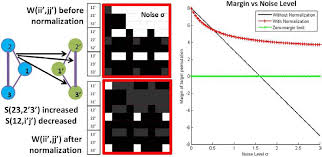</center>
<center> Figure 4: example of unbalanced matrix $W$ through synthetic noise example. Source: Cour et al. (2005) </center>

This has a direct consequence on the accuracy of the matching, as shown in figure 4 of this report (right figure). When the noise is zero, white boxes are "black", meaning that most of the edges are not connected to one another. Matrix $S$, before normalization, is thus very sparse and has positive potentials only on edges $(1, 1), (1, 1')$;  $(2, 2), (2, 2')$;  $(3, 3), (3, 3')$ but most importantly on edges  $(2, 1), (2', 1')$;  $(3, 1), (3', 1')$ and $(3,2), (3', 2')$. Citing the authors: "when the noise is small enough, the optimal matching is the desired permutation $p^* = \{11',22',33'\}$, with an initial score of 8 for $\sigma=0$". The latter computed the score of the second best permutation returned by the brute-force solving of the IQP as a function of noise level. From it, they displayed the difference between the graph matching score of 8 obtained before and the new optimal permutation depending on $\sigma$. This corresponds to the *margin*. Firstly, we see that the margin is stricly decreasing in $\sigma$ without the application of bistochastic normalization. In fact, for $\sigma > \sigma_0 \approx 1.6$, $p*$ is no longer optimal because the non informative edges outweight matrix $W$ and thus strongly affect the resulting optimal solution $x^*$ found. We talk about *spurious* connections to qualify the connections between edges (in $W$) which are not accurate and considerably decrease the influence of the other distinctive edges. According to the authors, this is the "main source of confusion for graph matching" and bistochastic normalization (BN) aims at fixing it. On our simplistic example, it drastically improves the optimal permutation returned by the algorithm and yield a matching which is robust to large noises put in the model. 

When we talk about *influence*, we can refer to the similarity matrix $S$. Indeed, the previous example showed the benefit of bistochastic normalization on rebalancing the influence of the connections between edges. In particular, the 2 columns of high influence in $S$ have globally been reduced by half in our example, whereas accurate connections weight have been increased. As a conclusion, spurious connections have been removed and informative ones enhanced. 

Hence $S$ measures the influence of those edges in the compatibility matrix, and, as we said,  is more suitable for analysing it. 

Bistochastic normalisation thus makes full use of matrix $S$ in order to decrease the influence of *non discriminative* edges and, on the contrary, increase the influence of a *discriminative* which has a small number of good matches. 

The principle of the bistochastic normalization is based on our previous observations: we would like, for SMAC and other relaxation methods to perform better, vertex and edge to match to a small number of vertices and edges respectively. In practise, this constraint would be very hard to apply. Nevertheless, Cour et al. (2005) suggest to normalize $S$ in such a way that to mimick this constraint. This corresponds to requiring $S$ to have each row and column "sum to 1", i.e., be bistochastic. However, $S$ can be rectangular of size $m \times m'$ and accordingly can not be a classical permutation matrix whose rows and columns sum to 1 (and mostly can't be a square matrix). That's why Cour et al. define a matrix $B$ of size $m \times m'$ as being **rectangular bistochastic** if it satisfies:
$$B \mathbf{1}_{m'} = \mathbf{1}_m \hspace{1cm} \text{and} \hspace{1cm} B \mathbf{1}_{m} = \frac{m}{m'}\mathbf{1}_{m'}$$

The second contribution of the article is the following theorem:

___
___

Under the condition $S >0$ elementwise, the problem consisting in finding $(D, D')$ such that $D$ and $D'$ are diagonal matrices of size $m, m'$ respectively and $DSD'$ is rectangular bistochastic, has a unique solution, $(D^*,D'^*)$ up to a scale factor. $D^*$ and $D'^*$ can be found by iteratively normalizing the rows and columns of $S$ as follows:


1.   Input: compatibility matrix $W$ of size $nn' \times nn'$

2.  Convert $W$ to $S$ through $S_{ij,i'j'}=W_{ii',jj'}$

3.   Repeat until convergence:
> 3.1 Normalize rows of $S$: $S_{ij,i'j}'^{t+1} := S_{ij,i'j'}^{t} \Big/  \sum_{k'l'} S_{ij,k'l'}^{t}$
> 3.2 Normalize columns of $S$: $S_{ij,i'j}'^{t+2} := S_{ij,i'j'}^{t+1} \Big/  \sum_{kl} S_{kl,i'j'}^{t+1}$

4. Convert back $S$ to $W$

5. Output: $W$ 
___
___

Let's now give a proof of the previous theorem. First, let's define the Kronecker product of a matrix $A$ of size $m \times n$ with $B$ of size $p \times q$ as the tensor product between $A$ and $B$. Namely, $$A \otimes B = \begin{pmatrix} a_{11} B & \cdots & a_{1n}B \\ \vdots & \ddots & \vdots \\ a_{m1} B & \cdots & a_{mn} B \end{pmatrix}$$
We now transform $S$ into a square matrix of size $mm' \times mm'$: $\bar{S} = S  \otimes  \mathbf{1}_{m' \times m}$ where $ \mathbf{1}_{m' \times m}$ is a matrix of ones of size $m' \times m$. Moreover, as $W$ is nonngeative, $\bar{S}$ is also nonnegative (elementwise). Cour et al. then use a very useful theorem in graph theory which was proposed and proved by Sinkhorn and Knopp in "Concerning nonegative matrices and boudly stochastic matrices" (1967). They showed the following result:

*let $A$ be a nonnegative square matrix. A necessary and sufficient condition that there exists a doubly stochastic matrix $B$ of the form $D_1 A D_2$ where $D_1$ and $D_2$ are diagonal matrices with positive main diagonals is that $A$ has total support. If $B$ exists then it is unique. Also, $D_1$ and $D_2$ are unique up to a sclaiar multiple if and only if $A$ is fully indecomposable. A necessary and sufficient condition that the iterative process of alternately normalizaing the rows and columns of $A$ will converge to a doubly stocahstic limit is that $A$ has support. If $A$ has total support, this limit is the described matrix $D_1AD_2$. If $A$ has support which is not total, this limit cannot be of the form $D_1AD_2$.*




Cour et al. apply this theorem to the square nonnegative matrix $\bar{S}$. Under the hypothesis that $S>0$ elementwise, $\bar{S}$ is also strictly positive elementwise. This allows to apply Sinkhorn et Knopp's theorem. Indeed, first, a matrix $A$ has total support if every $A_{ij} \neq 0$ belongs to some positive diagonal of $A$. Or, $A$ does not have total support if and only if there exists $A_{ij} \neq 0$ such that the submatrix obtained by deleting row $i$ and column $j$ has no positive diagonal. Here, all elements of $\bar{S}$ are strictly positive, so the latter matrix has total support. Then, a matrix $A$ is said to be  irreductible if there exists *no* permutation matrix $P$ such that $P^{-1}AP$ is equal to a block upper triangular matrix. In other words, a matrix is irreductible if it is not reductible. A useful theorem proved in, for example, A. Horn and R. Johnson, "Matrix analysis, second edition" (2013), theorem 6.2.23 p. 403,  is the following characterization of irreductible matrix: given a matrix $A \in M_n(\mathbb{R}$ nonnegative, $A$ is irreductible if and only if the matrix $(I_n + |A|)^{n-1}$ is strictly positive. In fact, here, $\bar{S}$ is strictly positive so, obviously, the latter condition is true. Hence, $\bar{S}$ has total support and is irreductible: Sinkhorn et Knopp's conditions are satisfied.  



Thus, there exists $2$ diagonal matrices of size $m \times m'$ such that $D_1 \bar{S} D_2$ is bistochastic. Now, let's remark that, as said by the authors, "normalizing rows and columns of $\bar{S}$ preserves kronecker structure", namely, for two diagonal matrices $(D, D')$ of size $m, m'$ respectively :
$$\bar{D} \bar{S} \bar{D}' = (D \otimes \mathbf{1}_{m' \times m'}) (S \otimes \mathbf{1}_{m' \times m}) (D' \otimes \mathbf{1}_{m \times m'}) = mm' DSD' \otimes \mathbf{1}_{m' \times m})$$ Let's briefly proves it. As $D$ and $D'$ are diagonal matrix, $\bar{D}$ and $\bar{D}'$ are block diagonal matrix of size $m \times m'$ with blocks of size $m' \times m'$ and $m \times m$ respectively. Thus, $\bar{D} \bar{S} \bar{D}'$ is a block full matrix with blocks of size $m' \times m$ equal to (we do write matrices of ones to avoid confusion):
$$\begin{pmatrix}
D_{11} S_{11,1'1'} D'_{1'1'} & ... & D_{11} S_{11,m'm'} D'_{m'm'} \\
D_{22} S_{21,1'1'} D'_{1'1'} & ... & D_{22}S_{21,m'm'} D'_{m'm'} \\
\vdots & \vdots & \vdots \\
\cdots & D_{ii} S_{ij,i'j'} D'_{j'j'} & ...  \\
\vdots & \vdots & \vdots \\
D_{mm} S_{mm,1'1'} D'_{1'1'} & ... & D_{mm} S_{mm,m'm'} D'_{m'm'} \\
\end{pmatrix}$$
where the general block term is equal to (exact formula with matrices of ones):
$$D_{ii}S_{ij,i'j'}D'_{j'j'}\mathbf{1}_{m' \times m'} \cdot  \mathbf{1}_{m' \times m} \cdot \mathbf{1}_{m \times m'}$$ Simple calculus then shows that:
$$\mathbf{1}_{m' \times m'} \cdot  \mathbf{1}_{m' \times m} \cdot \mathbf{1}_{m \times m'} = mm' \mathbf{1}_{m' \times m}$$ and thus $\bar{D} \bar{S} \bar{D}'$ is a block matrix with general block term equal to:
$$mm'  D_{ii}S_{ij,i'j'}D'_{j'j'} \mathbf{1}_{m' \times m}$$ which corresponds exactly to $mm' DSD' \otimes \mathbf{1}_{m' \times m}$ and concludes the proof. 

Now the authors state the following: * $(m^2 D, m' D')$ is solution for $S$ if and only if $(\bar{D}, \bar{D}')$ is solution for $\bar{S}$.* Where "solution for $S$" means that, for example, $m^2 m' DSD'$ is rectangular bistochastic as defined earlier. Let's prove it.   

* Suppose that $m^2 m' DSD'$ is rectangular bistochastic.
We first want to show that $\bar{D} \bar{S} \bar{D}' \mathbf{1}_{mm'} = \mathbf{1}_{mm'} $. Based on our latter result, 
$$\bar{D} \bar{S} \bar{D}' \mathbf{1}_{mm'} = mm' DSD' \otimes \mathbf{1}_{m' \times m} \cdot \mathbf{1}_{mm'}$$ Written in matrix form, the right-hand side term is a follows:

 
 \begin{equation*}
  mm' \times  \begin{array}{c@{\!\!\!}l}
  \left( \begin{array}[c]{ccccc}
    md_{11} S_{11,1'1'} d'_{1'1'} &+ ... +& md_{11} S_{11,m'm'} d'_{m'm'}  \\ 
\vdots & \cdots & \vdots\\
md_{11} S_{11,1'1'} d'_{1'1'} &+ ... +& md_{11} S_{11,m'm'} d'_{m'm'}  \\
md_{22} S_{21,1'1'} d'_{1'1'} &+ ... +& md_{22} S_{21,m'm'} d'_{m'm'}  \\ 
\vdots & \cdots & \vdots\\
md_{22} S_{21,1'1'} d'_{1'1'} &+ ... +& md_{22} S_{21,m'm'} d'_{m'm'}  \\ 
md_{mm} S_{mm,1'1'} d'_{1'1'} &+ ... +& md_{mm} S_{mm,m'm'} d'_{m'm'}  \\
\vdots & \cdots & \vdots\\
md_{mm} S_{mm,1'1'} d'_{1'1'} &+ ... +& md_{mm} S_{mm,m'm'} d'_{m'm'}  \\
  \end{array}  \right)
\end{array} \hspace{0.5cm} =  \hspace{0.5cm} m^2m' \times  \begin{array}{c@{\!\!\!}l}
  \left( \begin{array}[c]{ccccc}
    d_{11} S_{11,1'1'} d'_{1'1'} &+ ... +& d_{11} S_{11,m'm'} d'_{m'm'}  \\ 
\vdots & \cdots & \vdots\\
d_{11} S_{11,1'1'} d'_{1'1'} &+ ... +& d_{11} S_{11,m'm'} d'_{m'm'}  \\
d_{22} S_{21,1'1'} d'_{1'1'} &+ ... +& d_{22} S_{21,m'm'} d'_{m'm'}  \\ 
\vdots & \cdots & \vdots\\
d_{22} S_{21,1'1'} d'_{1'1'} &+ ... +& d_{22} S_{21,m'm'} d'_{m'm'}  \\ 
d_{mm} S_{mm,1'1'} d'_{1'1'} &+ ... +& d_{mm} S_{mm,m'm'} d'_{m'm'}  \\
\vdots & \cdots & \vdots\\
d_{mm} S_{mm,1'1'} d'_{1'1'} &+ ... +& d_{mm} S_{mm,m'm'} d'_{m'm'}  \\
  \end{array}  \right)
&
 \begin{array}[c]{@{}l@{\,}l}
\left. \begin{array}{c} \vphantom{0} \\ \vphantom{\vdots}
   \\ \vphantom{0}  \end{array} \right\} & \text{$m'$ times} \\
\left. \begin{array}{c} \vphantom{0}
  \\ \vphantom{\vdots} \\ \vphantom{0} \end{array} \right\} & \text{$m'$ times} \\
\left. \begin{array}{c} \vphantom{0}
  \\ \vphantom{\vdots} \\ \vphantom{0} \end{array} \right\} & \text{$m'$ times}
\end{array}
\end{array} 
\end{equation*}


But, we made the hypothesis that $m^2m'DSD'$ is rectangular bistochastic. Thus, $m'm^2DSD' \mathbf{1}_m = \mathbf{1}_m$ and it directly implies that each element of the above vector is equal to 1. Finally, we thus showed that $\bar{D} \bar{S} \bar{D}' \mathbf{1}_{mm'} = \mathbf{1}_{mm'} $. Now, we need to prove that $\Big(\bar{D} \bar{S} \bar{D}' \Big)^\top\mathbf{1}_{mm'} = \mathbf{1}_{mm'} $. One may recall that a second implication of our hypothesis is that $m'm^2\Big(DSD' \Big)^\top\mathbf{1}_{m'} = (m/m') \mathbf{1}_{m'}$ which is the same as $m'^2m\Big(DSD' \Big)^\top\mathbf{1}_{m'} = \mathbf{1}_{m'}$. This second formulation is very similar to that of the other condition. In fact, if we apply the same reasoning as before with transposed matrix, we exactly fall back to the same proof as above. Once we proved the first characterization of the permutation matrix $\bar{D} \bar{S} \bar{D}'$, the symmetric one is strainghtforward. Hence, we've just shown the left to right implication. It means that, if $(m^2 D, m'D')$ is a solution for normalizing $S$, then $(\bar{D}, \bar{D}')$ is a solution for normalizing $\bar{S}$. Using the uniqueness of the decomposition into a bistochastic square matrix of $\bar{S}$ according to Sinkhorn and Knopp's theorem, we have that $D_1=\bar{D}$ and $D_2=\bar{D}'$ up to a numerical constant that we omit here for more clarity. Now, let's prove the other way around.

* Suppose that $\bar{D} \bar{S} \bar{D}' $ is a square bistochastic matrix of size $mm' \times mm'$.
We first want to show that $m'm^2 DSD' \mathbf{1}_{m} = \mathbf{1}_{m} $. Once again, we base our proof on our first result, 
$$\bar{D} \bar{S} \bar{D}' = mm' DSD' \otimes \mathbf{1}_{m' \times m}$$ Our hypothesis implies that:
$$\bar{D} \bar{S} \bar{D}' \mathbf{1}_{mm'} = mm' DSD' \otimes \mathbf{1}_{m' \times m} \cdot \mathbf{1}_{mm'} = \mathbf{1}_{mm'} $$

Written in matrix form, this is equivalent to:

 \begin{equation*}
  m^2m' \times  \begin{array}{c@{\!\!\!}l}
  \left( \begin{array}[c]{ccccc}
    d_{11} S_{11,1'1'} d'_{1'1'} &+ ... +& d_{11} S_{11,m'm'} d'_{m'm'}  \\ 
\vdots & \cdots & \vdots\\
d_{11} S_{11,1'1'} d'_{1'1'} &+ ... +& d_{11} S_{11,m'm'} d'_{m'm'}  \\
d_{22} S_{21,1'1'} d'_{1'1'} &+ ... +& d_{22} S_{21,m'm'} d'_{m'm'}  \\ 
\vdots & \cdots & \vdots\\
d_{22} S_{21,1'1'} d'_{1'1'} &+ ... +& d_{22} S_{21,m'm'} d'_{m'm'}  \\ 
d_{mm} S_{mm,1'1'} d'_{1'1'} &+ ... +& d_{mm} S_{mm,m'm'} d'_{m'm'}  \\
\vdots & \cdots & \vdots\\
d_{mm} S_{mm,1'1'} d'_{1'1'} &+ ... +& d_{mm} S_{mm,m'm'} d'_{m'm'}  \\
  \end{array}  \right)
& = & \left( \begin{array}[c]{c}
1  \\
\vdots \\
1  \\
1 \\
\vdots \\
1 \\
1 \\ 
\vdots \\
1 \\
\end{array} \right)
 \begin{array}[c]{@{}l@{\,}l}
\left. \begin{array}{c} \vphantom{0} \\ \vphantom{\vdots}
   \\ \vphantom{0}  \end{array} \right\} & \text{$m'$ times} \\
\left. \begin{array}{c} \vphantom{0}
  \\ \vphantom{\vdots} \\ \vphantom{0} \end{array} \right\} & \text{$m'$ times} \\
\left. \begin{array}{c} \vphantom{0}
  \\ \vphantom{\vdots} \\ \vphantom{0} \end{array} \right\} & \text{$m'$ times}
\end{array}
\end{array} 
\end{equation*}


We clearly see that, on the $mm'$ conditions above, there are exactly $m$ unique conditions, more specifically:

 \begin{equation*}
  m^2m' \times  \begin{array}{c@{\!\!\!}l}
  \left( \begin{array}[c]{ccccc}
    d_{11} S_{11,1'1'} d'_{1'1'} &+ ... +& d_{11} S_{11,m'm'} d'_{m'm'}  \\ 
\vdots & \cdots & \vdots\\
d_{mm} S_{mm,1'1'} d'_{1'1'} &+ ... +& d_{mm} S_{mm,m'm'} d'_{m'm'}  \\
  \end{array}  \right)
& = & \left( \begin{array}[c]{c}
1  \\
\vdots \\
1  \\
\end{array} \right)
 \begin{array}[c]{@{}l@{\,}l}
\left. \begin{array}{c} \vphantom{0}
  \\ \vphantom{\vdots} \\ \vphantom{0} \end{array} \right\} & \text{$m$ times}
\end{array}
\end{array} 
\end{equation*}
which is equivalent to writing:  $m^2 m' DSD \mathbf{1}_m = \mathbf{1}_m$. We thus proved the first characterization of $(D, D')$ being a solution for $S$. The second is strainghtforward once we've done that. Indeed, we now want to prove that $m^2 m' \Big(DSD\Big)^\top \mathbf{1}_{m'} = \frac{m}{m'}\mathbf{1}_{m'}$ which is equivalent to showing that $m m'^2 \Big(DSD\Big)^\top \mathbf{1}_{m'} = \mathbf{1}_{m'}$.


Our hypothesis also implies that:
$$\Big(\bar{D} \bar{S} \bar{D}'\Big)^\top \mathbf{1}_{mm'} = mm' \Big(DSD' \otimes \mathbf{1}_{m' \times m} \Big)^\top \cdot \mathbf{1}_{mm'} = \mathbf{1}_{mm'} $$

Similarly to the previous derivations, we can write this in matrix form as:

 \begin{equation*}
  m'^2m \times  \begin{array}{c@{\!\!\!}l}
  \left( \begin{array}[c]{ccccc}
    d_{11} S_{11,1'1'} d'_{1'1'} &+ ... +&  d_{mm} S_{mm,1'1'} d'_{1'1'}  \\ 
\vdots & \cdots & \vdots\\
    d_{11} S_{11,1'1'} d'_{1'1'} &+ ... +&  d_{mm} S_{mm,1'1'} d'_{1'1'}  \\ 
 \vdots & \cdots & \vdots\\   
d_{11} S_{11,m'm'} d'_{m'm'} &+ ... +& d_{mm} S_{mm,m'm'} d'_{m'm'}  \\
\vdots & \cdots & \vdots\\
d_{11} S_{11,m'm'} d'_{m'm'} &+ ... +& d_{mm} S_{mm,m'm'} d'_{m'm'}  \\
  \end{array}  \right)
& = & \left( \begin{array}[c]{c}
1  \\
\vdots \\
1  \\
\vdots \\
1 \\
\vdots \\
1 \\
\end{array} \right)
 \begin{array}[c]{@{}l@{\,}l}
\left. \begin{array}{c} \vphantom{0} \\ \vphantom{\vdots}
   \\ \vphantom{0}  \end{array} \right\} & \text{$m$ times} \\ \\
\left. \begin{array}{c} \vphantom{0}
  \\ \vphantom{\vdots} \\ \vphantom{0} \end{array} \right\} & \text{$m$ times} 
\end{array}
\end{array} 
\end{equation*}
Which represent $mm'$ redundant conditions but only $m'$ unique conditions:
 \begin{equation*}
  m'^2m \times  \begin{array}{c@{\!\!\!}l}
  \left( \begin{array}[c]{ccccc}
    d_{11} S_{11,1'1'} d'_{1'1'} &+ ... +&  d_{mm} S_{mm,1'1'} d'_{1'1'}  \\ 
\vdots & \cdots & \vdots\\
d_{11} S_{11,m'm'} d'_{m'm'} &+ ... +& d_{mm} S_{mm,m'm'} d'_{m'm'}  \\
  \end{array}  \right)
& = & \left( \begin{array}[c]{c}
1  \\
\vdots \\
1  \\
\end{array} \right)
 \begin{array}[c]{@{}l@{\,}l}
\left. \begin{array}{c} \vphantom{0} \\ \vphantom{\vdots}
   \\ \vphantom{0}  \end{array} \right\} & \text{$m'$ times}
\end{array}
\end{array} 
\end{equation*} and is strictly equivalent to the more compact formulation: $m m'^2 \Big(DSD\Big)^\top \mathbf{1}_{m'} = \mathbf{1}_{m'}$ and concludes the proof of the validity of bistochastic rectangular normalization algorithm.

Cour et al. here proove an important result which can be a generalization of Sinkhorn et Knopp's theorem to positive rectanguler matrix : if a matrix is positive rectangular, then, the algorithm which consists in normalizing successively the rows and columns of $S$ makes $S$ converge to rectangular bistochastic matrix which can be decomposed as $DSD'$ with $D, D'$ of size $m, m'$ respectively and obtained through the process of normalization. To come back to the proof, the fact that normalizing rows ans columns of $\bar{S}$ preserves the kronecker structure is essential. To sum up, we showed that:

1. $\bar{S}$ can be decomposed as a bistochastic square matrix $D_1 \bar{S} D_2$ by normalizing successively the rows and columns of $\bar{S}$
2. Then, normalizing rows ans columns of $\bar{S}$ preserves the kronecker structure. It means that $(D, D')$ and $(\bar{D}, \bar{D'})$ are equivalent. In a sens that normalizing $\bar{S}$ in such a way leads to a decomposition pair $(\bar{D}, \bar{D'})$ that can related to the decomposition pair $(D, D')$ obtained by normalizing $S$, thanks to kronecker strcture and up to a scale factor.
3. Uniqueness of the decomposition of $\bar{S}$ implies that $(D_1, D_2) = (\bar{D}, \bar{D'})$ thanks to Sinkhorn et Knopp's theorem. 

As a conclusion, the bistochastic normalization algorithm will converge to a bistochastic rectangular matrix. 

## Experiments

We tried the described algorithms with one-to-one matching problems for randomly generated graph with the addition of synthetic noise. We proceeded as follow:
* Select a number of nodes $n$ and a number of edge $m$ for each graph G1 and G2
* Randomly draw $m$ edges among the $n(n-1)/2$ possibilities (undirected graphs) for G1
* Randomly draw a permutation $P$ of the vertices of the G1, such as each edge $(i, j)$ of G1 gives the edge $(P(i), P(j))$ for G2.
* Assign independant attributes to each edge/vertice of G1 according to a probability distribution $Q$
* Assign the same attribute for the corresponding edge/vertice of G2 with addition of a synthetic noise drawn according to a distribution $S_v$ for the vertices, then $S_e$ for the edges (which can depend on the realisation of the noise for the vertices. This gives the generic form of the attributes matrix:
$$
A_{P(i)P(i)} = A_{i, i}+ s_v(i)
$$
and
$$
A_{P(i)P(j)} = A_{i, j}+ s_e(i, j)
$$
With $s_v(i) \sim S_v $ $\forall i$ and $s_e(i, j) \sim S_e(. |s_v(i), s_v(j))$ $ \forall (i, j)$.

As we saw in the first section, with all these elements we are able to compute the compatibility matrix $W$. For this, we only need to properly define a matching function $D_M: (x,y) \rightarrow D_M(x,y)\in \mathbb{R}$. For each problem we defined we tested two versions of the algorithms: the first one using the "raw" $W$ and the second one using the bistochastic normalization, so we could compare the two methods.

Our graph generation algorithms are below, along with a simple exponential distance metric.

In [10]:
def generate_random_graph(n, m, draw_attribute=np.random.uniform):
    """
    :param n: number of vertices
    :param m: number of edges
    :param draw_attribute: Distribution for the parameter
    :return: tuple (n, set of edges, attribute matrix A)
    """
    edge_set = list(combinations(np.arange(n), 2))
    edges_indices = np.random.choice(len(edge_set), replace=False, size=m)
    edges = [edge_set[i] for i in edges_indices]
    A = np.zeros((n, n))
    for e in edges:
        A[e[0], e[1]] = draw_attribute()
    A = A+A.T
    A += np.diag(draw_attribute(size=n))
    return n, edges, A


def get_perturbed_graph(graph, noise_level, draw_noise=np.random.uniform):
    n, E, A = graph
    indices = np.arange(n)
    np.random.shuffle(indices)
    Ep = []
    Ap = np.zeros(A.shape)
    for e in E:
        new_e = (indices[e[0]], indices[e[1]])
        Ep.append(new_e)
        Ap[new_e[0], new_e[1]] = A[e[0], e[1]] + draw_noise(0, noise_level)
    Ap = Ap + Ap.T
    for i, x in enumerate(indices):
        Ap[x, x] = A[i, i] + draw_noise(0, noise_level)
    return n, Ep, Ap, indices


def exp_dist(x, y):
    return np.exp(-np.sum(np.abs(x-y)**2))

Before further describing our experiments, we can detail the metrics that can be used to evaluate the algorithms. We were inspired by the different figures proposed in the original paper, and implemented:
* A score computation, that provide the average percentage of correct matches for a given algorithm/experiment. We also added a little variant that provides the ratio of perfectly matched graph. These scores are obtained by considering the "ground truth" permutation used to sample G2 as the best matching. Not that depending of the noise and edge structure this may not actually be the best matching regarding to the data, but for reasonable noise it is generally the case.
* A regret indicator by computing the average difference between the ground truth objective $x_P^T W x_P$ and the objective attained by the algorithm $x_{opt}^T W x_{opt}$. The idea is to approximate the indicator $\mathbb{E}_{Q, S_v, S_e}(x_P^T W x_P-x_{opt}^T W x_{opt})$ for a given problem type. We could then compare these indicators for each algorithm and for different noise levels.

### Further description of our experiments and results

In our experiments we mixed uniform and gaussian distributions for the attributes of G1 and the noise of G2. 

The attributes were distributed either according to a uniform $\mathcal{U}([0,1])$ or a standard Gaussian $\mathcal{N}(0, 1)$.

The additional noise were always added with 0 means, such as the distribution can be summarized by only one parameter $\sigma$: $n \sim \mathcal{U}([-\sigma/2,\sigma/2])$ or $n \sim \mathcal{N}(0, \sigma^2)$. From now we will generally talk of "a noise level of $\sigma$" in both cases for convenience, even if they do not represent the same quantity in practice ($V(n)=\sigma^2$ for the gaussian and $V(n)= \sigma^2/12$ for uniform).
The functions below can generate these kind of graph.

In [12]:
def generate_random_graph(n, m, draw_attribute=np.random.uniform):
    """
    :param n: number of vertices
    :param m: number of edges
    :param draw_attribute: Distribution for the parameter
    :return: tuple (n, set of edges, attribute matrix A)
    """
    edge_set = list(combinations(np.arange(n), 2))
    edges_indices = np.random.choice(len(edge_set), replace=False, size=m)
    edges = [edge_set[i] for i in edges_indices]
    A = np.zeros((n, n))
    for e in edges:
        A[e[0], e[1]] = draw_attribute()
    A = A+A.T
    A += np.diag(draw_attribute(size=n))
    return n, edges, A


def get_perturbed_graph(graph, noise_param=(-1, 1), draw_noise=np.random.uniform):
    """
    :param graph: First graph G1
    :param noise_param: Parameters of the distribution of the noise 
    :param draw_noise: noise distribution 
    :return: Perturbed permutation of the initial graph
    """
    n, E, A = graph
    indices = np.arange(n)
    np.random.shuffle(indices)
    Ep = []
    Ap = np.zeros(A.shape)
    for e in E:
        new_e = (indices[e[0]], indices[e[1]])
        Ep.append(new_e)
        Ap[new_e[0], new_e[1]] = A[e[0], e[1]] + draw_noise(*noise_param)
    Ap = Ap + Ap.T
    for i, x in enumerate(indices):
        Ap[x, x] = A[i, i] + draw_noise(*noise_param)
    return n, Ep, Ap, indices
